In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt

In [3]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [5]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
missing_cols = [c for c in cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Expected columns not found in the dataset: {missing_cols}")

df = df[cols].copy()

for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


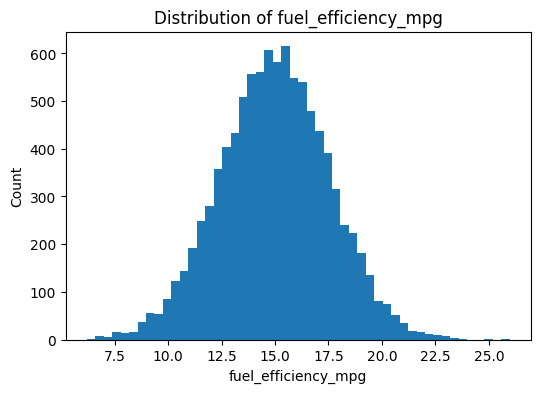

Skewness: -0.012062219273507922
Comment: If skewness is >> 0 and the histogram has a heavy right tail, it's long-tailed.


In [6]:
fuel_efficiency_mpg = df['fuel_efficiency_mpg'].dropna()

plt.figure(figsize=(6, 4))
plt.hist(fuel_efficiency_mpg, bins=50)
plt.title("Distribution of fuel_efficiency_mpg")
plt.xlabel("fuel_efficiency_mpg")
plt.ylabel("Count")
plt.show()

print("Skewness:", fuel_efficiency_mpg.skew())
print("Comment: If skewness is >> 0 and the histogram has a heavy right tail, it's long-tailed.")

In [7]:
na_counts = df.isnull().sum().sort_values(ascending=False)
display(na_counts)

q1_answer = na_counts.idxmax() if (na_counts.max() > 0) else "no_missing"
print(q1_answer)

horsepower             708
engine_displacement      0
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

horsepower


In [8]:
horsepower_median = float(df['horsepower'].median())
print(horsepower_median)

149.0


In [19]:
def shuffle_split(df, seed=42, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-8
    n = len(df)
    idx = np.arange(n)
    rng = np.random.RandomState(seed)
    rng.shuffle(idx)

    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train + n_val]
    test_idx = idx[n_train + n_val:]

    return df.iloc[train_idx].copy(), df.iloc[val_idx].copy(), df.iloc[test_idx].copy()

In [20]:
df_full = df.copy()
df_train, df_val, df_test = shuffle_split(df_full, seed=42, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

y_train = df_train['fuel_efficiency_mpg'].values
y_val   = df_val['fuel_efficiency_mpg'].values
y_test  = df_test['fuel_efficiency_mpg'].values

feats = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
X_train_raw = df_train[feats].copy()
X_val_raw   = df_val[feats].copy()
X_test_raw  = df_test[feats].copy()

len(df_train), len(df_val), len(df_test)

(5822, 1940, 1942)

In [21]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 100)

def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())

def prepare_X(df, features=('ram', 'storage', 'screen')):
    X = df[list(features)].copy()
    # Coerce to numeric in case any column is parsed as strings (e.g., '8', '512', etc.)
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors='coerce')
    X = X.fillna(0)  # defensive; imputation choices are applied earlier in the pipeline
    # Add intercept
    X = np.column_stack([np.ones(len(X)), X.values])
    return X

def train_linear_regression(X, y):
    # Normal equation: w = (X^T X)^(-1) X^T y
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w

def train_linear_regression_reg(X, y, r=0.0):
    # Ridge-regularized closed-form: w = (X^T X + r*I)^(-1) X^T y
    XTX = X.T.dot(X)
    # Don't regularize the bias term
    reg = np.eye(XTX.shape[0])
    reg[0, 0] = 0.0
    XTX_reg = XTX + r * reg
    XTX_inv = np.linalg.inv(XTX_reg)
    w = XTX_inv.dot(X.T).dot(y)
    return w

def predict(X, w):
    return X.dot(w)

In [23]:
col_with_na = df.columns[df.isnull().any()].tolist()
col_with_na = col_with_na[0] if len(col_with_na) > 0 else None
print("Column with NA (from data):", col_with_na)

def impute_and_train(strategy='zero'):
    X_tr = X_train_raw.copy()
    X_v  = X_val_raw.copy()

    if col_with_na is not None:
        if strategy == 'zero':
            X_tr[col_with_na] = X_tr[col_with_na].fillna(0)
            X_v[col_with_na]  = X_v[col_with_na].fillna(0)
        elif strategy == 'mean':
            mean_val = X_tr[col_with_na].mean()
            X_tr[col_with_na] = X_tr[col_with_na].fillna(mean_val)
            X_v[col_with_na]  = X_v[col_with_na].fillna(mean_val)
        else:
            raise ValueError("Unknown strategy")

    # For safety, coerce to numeric (if any string sneaks in)
    for c in X_tr.columns:
        X_tr[c] = pd.to_numeric(X_tr[c], errors='coerce')
        X_v[c]  = pd.to_numeric(X_v[c], errors='coerce')

    X_tr = prepare_X(pd.concat([X_tr, df_train[['fuel_efficiency_mpg']]], axis=1), features=feats)
    X_v  = prepare_X(pd.concat([X_v,  df_val[['fuel_efficiency_mpg']]],   axis=1), features=feats)

    w = train_linear_regression(X_tr, y_train)
    pred = predict(X_v, w)
    return rmse(y_val, pred)

rmse_zero = impute_and_train('zero')
rmse_mean = impute_and_train('mean')

print("Validation RMSE with 0   :", round(rmse_zero, 2))
print("Validation RMSE with mean:", round(rmse_mean, 2))

q3_answer = "With 0" if round(rmse_zero, 2) < round(rmse_mean, 2) else ("With mean" if round(rmse_mean, 2) < round(rmse_zero, 2) else "Both are equally good")
print(q3_answer)

Column with NA (from data): horsepower
Validation RMSE with 0   : 0.52
Validation RMSE with mean: 0.46
With mean


In [26]:
X_tr0 = X_train_raw.copy().fillna(0)
X_v0  = X_val_raw.copy().fillna(0)

for c in feats:
    X_tr0[c] = pd.to_numeric(X_tr0[c], errors='coerce').fillna(0)
    X_v0[c]  = pd.to_numeric(X_v0[c], errors='coerce').fillna(0)

X_tr0 = X_tr0.values
X_v0  = X_v0.values

r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
val_scores = {}

w0_fixed = 7.17

for r in r_values:
    # Ridge regression closed form for weights (no bias term)
    XTX = X_tr0.T.dot(X_tr0)
    reg = np.eye(XTX.shape[0])
    XTX_reg = XTX + r * reg
    w_rest = np.linalg.inv(XTX_reg).dot(X_tr0.T).dot(y_train)

    # Prediction: add bias manually
    y_pred = X_v0.dot(w_rest) + w0_fixed
    score = round(rmse(y_val, y_pred), 2)
    val_scores[r] = score
    print(f"r={r:<5} -> val RMSE = {score}")

# Select r with lowest RMSE, break ties by picking the lowest r
min_rmse = min(val_scores.values())
best_r = min([r for r, s in val_scores.items() if s == min_rmse])

print("Best r =", best_r, "with RMSE =", val_scores[best_r])

r=0     -> val RMSE = 7.19
r=0.01  -> val RMSE = 7.19
r=0.1   -> val RMSE = 7.19
r=1     -> val RMSE = 7.19
r=5     -> val RMSE = 7.19
r=10    -> val RMSE = 7.19
r=100   -> val RMSE = 7.19
Best r = 0 with RMSE = 7.19


In [33]:

seeds = list(range(10))
val_rmses = []

for s in seeds:
    tr, va, te = shuffle_split(df_full, seed=s, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

    y_tr = va_target = None
    y_tr  = tr['fuel_efficiency_mpg'].values
    y_va  = va['fuel_efficiency_mpg'].values

    Xtr = tr[feats].copy().fillna(0)
    Xva = va[feats].copy().fillna(0)

    for c in feats:
        Xtr[c] = pd.to_numeric(Xtr[c], errors='coerce').fillna(0)
        Xva[c] = pd.to_numeric(Xva[c], errors='coerce').fillna(0)

    Xtr = prepare_X(pd.concat([Xtr, tr[['fuel_efficiency_mpg']]], axis=1), features=feats)
    Xva = prepare_X(pd.concat([Xva, va[['fuel_efficiency_mpg']]], axis=1), features=feats)

    w = train_linear_regression(Xtr, y_tr)
    preds = predict(Xva, w)
    r = rmse(y_va, preds)
    val_rmses.append(r)

std_scores = float(np.std(val_rmses))
print("Validation RMSEs:", [round(v, 2) for v in val_rmses])
print("Std of validation RMSEs across seeds:", round(std_scores, 3))


Validation RMSEs: [np.float64(0.52), np.float64(0.52), np.float64(0.52), np.float64(0.52), np.float64(0.51), np.float64(0.53), np.float64(0.53), np.float64(0.51), np.float64(0.51), np.float64(0.51)]
Std of validation RMSEs across seeds: 0.007


In [31]:

tr, va, te = shuffle_split(df_full, seed=9, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

train_full = pd.concat([tr, va]).reset_index(drop=True)

y_train_full = train_full['fuel_efficiency_mpg'].values
y_test = te['fuel_efficiency_mpg'].values

X_train_full = train_full[feats].copy().fillna(0)
X_test0       = te[feats].copy().fillna(0)

for c in feats:
    X_train_full[c] = pd.to_numeric(X_train_full[c], errors='coerce').fillna(0)
    X_test0[c]      = pd.to_numeric(X_test0[c], errors='coerce').fillna(0)

X_train_full = prepare_X(pd.concat([X_train_full, train_full[['fuel_efficiency_mpg']]], axis=1), features=feats)
X_test0      = prepare_X(pd.concat([X_test0,      te[['fuel_efficiency_mpg']]],       axis=1), features=feats)

w = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)
y_pred_test = predict(X_test0, w)
test_rmse = rmse(y_test, y_pred_test)

print("Test RMSE with r=0.001 (seed=9):", round(test_rmse, 3))


Test RMSE with r=0.001 (seed=9): 0.515
